* Input: embeddings in `io/` directory.
* Output: graphs

In [1]:
import json
from pathlib import Path
from ast import literal_eval
from typing import Tuple, Union, List
import numpy as np
import pandas as pd

import stats
import sys
import msgpack
from zipfile import ZipFile, ZipInfo
from pprint import pprint

In [2]:
n = 30
noise = "human"
DIR = Path("io/2021-03-09/")
EMBEDDINGS = DIR / "embeddings.zip"

In [3]:
# EM_DIR = DIR / "embeddings"
SALMON_DIR = Path.home() / "Developer" / "stsievert" / "salmon"
sys.path.append(str(SALMON_DIR / "examples"))

In [4]:
def _get_config(name):
    return _get_dict(
        name.replace(".msgpack", "")
        .replace(".csv", "")
        .replace("responses*", "")
    )

def _get(file: Union[Path, bytes], history=False) -> Union[Tuple[np.ndarray, dict], List[dict]]:
    if isinstance(file, (Path, str)):
        with open(file, "rb") as f:
            data = msgpack.load(f)
    else:
        data = msgpack.loads(file)
    em = data.pop("embedding")
    meta = data.pop("meta")
    perf = data.pop("performance")
    if history:
        return data["history"]
    for k, v in perf.items():
        meta[f"perf__{k}"] = v
    return em, meta

In [5]:
# keys = [k for k in RESPONSES_DIR.glob("*.csv") if "alg=RandomSampling" in str(k)]
# assert len(keys) == 1, len(keys)
# random_responses = pd.read_csv(keys[0])
# from sklearn.model_selection import train_test_split
# _, df_test = train_test_split(random_responses, test_size=0.2, random_state=42)
# print(keys)
# X_test = df_test[["head", "winner", "loser"]].to_numpy()

from run import _X_test
X_test = _X_test()

In [6]:
data = []
with ZipFile(EMBEDDINGS, "r") as myzip:
    files = [f for f in myzip.filelist if ".msgpack" in f.filename]
    for k, f in enumerate(myzip.filelist):
        datum, em = _get(myzip.read(f))
        data.append(_get(myzip.read(f)))
        

In [7]:
import yaml
with open(DIR / "config_RR.yaml", "r") as f:
    config = yaml.safe_load(f)
rare = [t.split("/")[-2] for t in config["targets"]]
mrare = [t.strip("i.png' ") for t in rare]
targets = [int(t) for t in mrare]
perf = [{**meta, **stats.collect(embedding, targets, X_test)} for embedding, meta in data]
len(perf)

1242

In [8]:
def _ground_truth(h, l, r):
    dl = np.abs(h - l)
    dr = np.abs(h - r)
    return "left" if dl < dr else "right"

N = range(30)
X_test = np.array([
    (hi, li, ri) if _ground_truth(h, l, r) == "left" else (hi, ri, li)
    for hi, h in enumerate(targets)
    for li, l in enumerate(targets)
    for ri, r in enumerate(targets)
    if h != l and h != r and r != l
])
X_test.shape
X_test

array([[ 0,  1,  2],
       [ 0,  1,  3],
       [ 0,  1,  4],
       ...,
       [29, 28, 25],
       [29, 28, 26],
       [29, 28, 27]])

In [9]:
import datasets

In [10]:
df = pd.DataFrame(perf)

fname = ""
online = pd.read_csv(DIR / "history_RR.csv")
online["alg"] = online["perf__ident"] = "RR (online)"

print(df.ident.unique())
df["sampling"] = df.ident.apply(lambda s: s.split("-")[0] if "next" not in s else "next")
print(df.sampling.unique())
df["embedding"] = df.ident.apply(lambda s: s.split("-")[-1])
online["sampling"] = "online"
online["embedding"] = "online"
df = pd.concat((df, online))
print("df.shape =", df.shape)

df.drop(columns=["css", "debrief", "instructions", "samplers"], inplace=True)
df.head()

['random-SOE' 'random_next-TSTE' 'random_next-CKL' 'active-CKL'
 'active-SOE' 'random-GNMDS' 'random_next-SOE' 'active-TSTE' 'random-TSTE'
 'random_next-GNMDS' 'active-GNMDS' 'random-CKL']
['random' 'next' 'active']
df.shape = (1529, 101)


,d,max_queries,n,sampling,skip_button,ident,est__dwell,est__verbose,est__random_state,est__max_epochs,...,est__module__mu,embedding,Unnamed: 0,R,dataset,random_state,reaction_time,response_time,init,n_users
0,2,-1,30,random,False,random-SOE,1000.0,1000.0,0.0,400000.0,...,NaN,SOE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-1,30,next,False,random_next-TSTE,1000.0,1000.0,7.0,400000.0,...,NaN,TSTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-1,30,random,False,random-SOE,1000.0,1000.0,6.0,400000.0,...,NaN,SOE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,-1,30,next,False,random_next-CKL,1000.0,1000.0,7.0,400000.0,...,0.05,CKL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,-1,30,next,False,random_next-TSTE,1000.0,1000.0,4.0,400000.0,...,NaN,TSTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.sampling.unique()

array(['random', 'next', 'active', 'online'], dtype=object)

In [12]:
df.alg.unique()

array(['random', 'random_next', 'active', 'RR (online)'], dtype=object)

In [13]:
df.columns

Index(['d', 'max_queries', 'n', 'sampling', 'skip_button', 'ident',
       'est__dwell', 'est__verbose', 'est__random_state', 'est__max_epochs',
       'n_train', 'n_test', 'n_responses', 'noise_model', 'threads', 'alg',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_error', 'embedding_rel_error',
       'procrustes_disparity', 'nn_diff_0'

In [14]:
HUE_ORDER = ["random", "active"]#, "online"]#, "next"]

(0.0, 2.0)

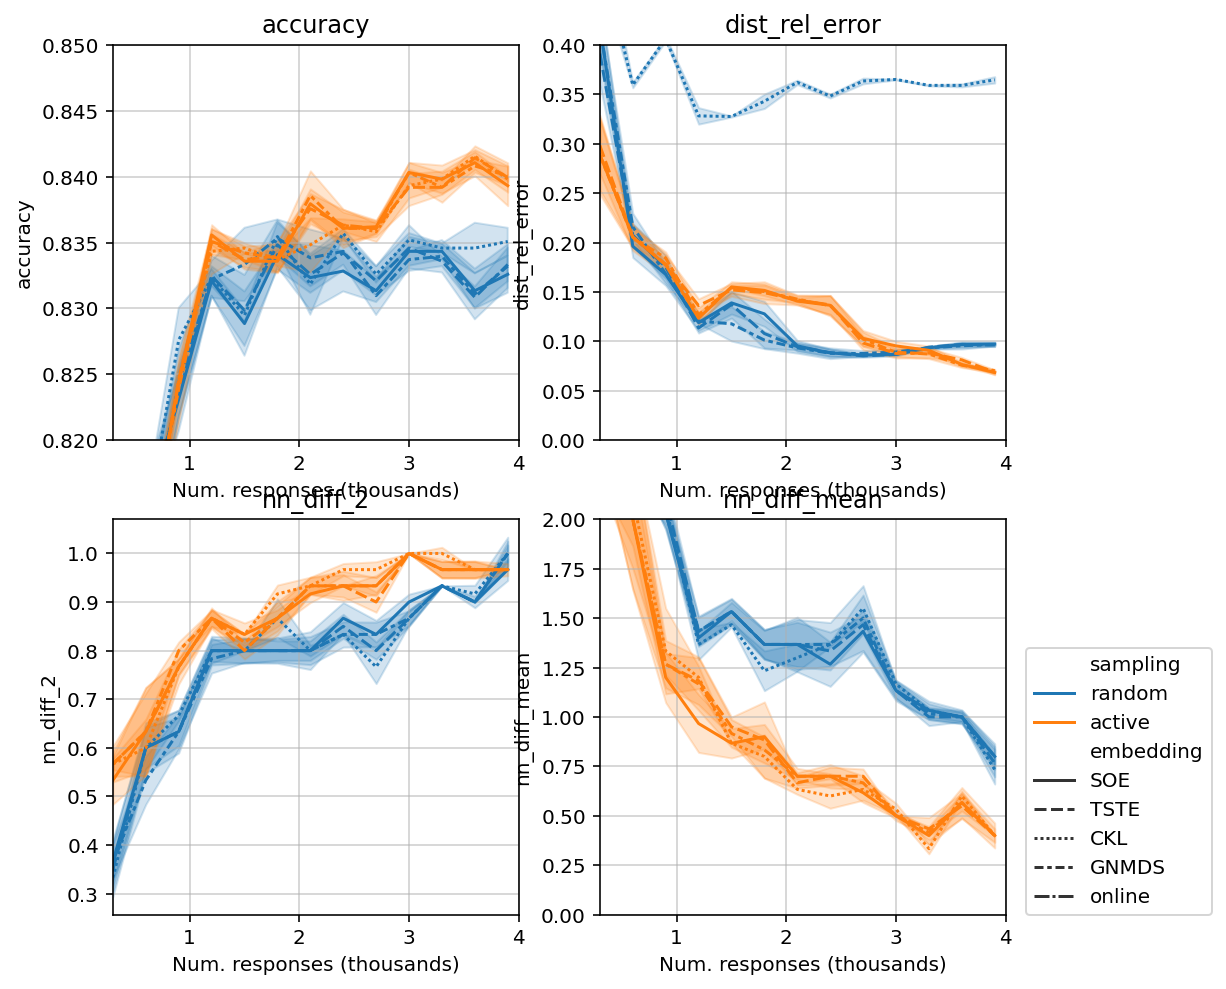

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

df["n_responses/1000"] = df.n_responses / 1000
Y = ["accuracy", "dist_rel_error", "nn_diff_2", "nn_diff_mean"]
# Y = ["accuracy", "perf__loss_test", "embedding_rel_error", "nn_diff_mean"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for k, (y, ax) in enumerate(zip(Y, axs.flatten())):
    ax = sns.lineplot(
        x="n_responses/1000",
        y=y,
        hue="sampling",
        style="embedding",
        hue_order=HUE_ORDER,
#         marker="o",
#         data=df,
        data=df,#[df.embedding.isin(["online", "CKL"])],
        ax=ax,
        ci="sd",
        estimator="median",
    )
    _ = ax.set_xlabel("Num. responses (thousands)")
    ax.grid(alpha=0.6)
    if k != 3:
        ax.legend_.remove()
    else:
        ax.legend(loc=(1.05, 0))
    _ = ax.set_title(y)
    
#     ax.set_xscale("log")
    if "accu" in y:
        _ = ax.set_ylim(0.82, 0.85)
    elif "nn_acc" in y:
        _ = ax.set_ylim(0.0, 1.05)
    elif "nn_diff_mean" in y:
        ax.set_ylim(0, 2)
    _ = ax.set_xlim(0, 8)
    _ = ax.set_xlim(0.3, 4)
    if "rel_error" in y:
        _ = ax.set_ylim(0, 0.4)


In [17]:
from functools import partial
def lineplot(*, x, y, data, hue, hue_order, style, estimator="median", ci=0.25, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for h in hue_order:
        show = data.loc[data[hue] == h, [x, y]]
        kwargs = dict(index=x, values=y)
        middle = show.pivot_table(**kwargs, aggfunc=estimator)
        _lower = partial(np.percentile, q=100*ci)
        _upper = partial(np.percentile, q=100 * (1 - ci))

        lower = show.pivot_table(**kwargs, aggfunc=_lower)
        upper = show.pivot_table(**kwargs, aggfunc=_upper)
        if len(middle):
            ax.plot(middle.index, middle.values, label=h)
            assert (lower.index == upper.index).all()
            ax.fill_between(lower.index, lower.values.flatten(), upper.values.flatten(), alpha=0.3)
    ax.legend(loc="best")
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    return ax

In [18]:
# sorted(list(df.columns))

In [19]:
df.sampling.unique()

array(['random', 'next', 'active', 'online'], dtype=object)

['random' 'next' 'active' 'online']
39


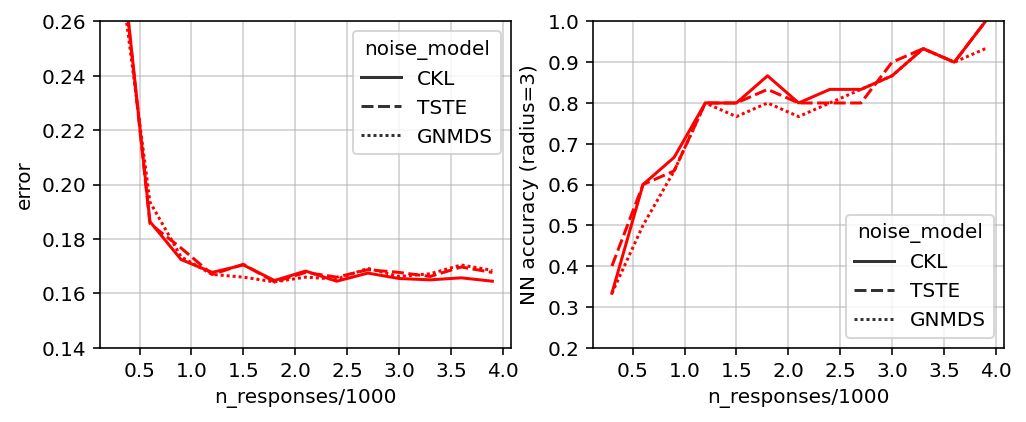

In [20]:
w = 3

print(df.sampling.unique())
idx = (df.sampling == "random") & (df.est__random_state == 1) & (df.noise_model.isin(["CKL", "TSTE", "GNMDS"]))
s = df[idx].copy()
s["error"] = 1 - s["accuracy"]
print(len(s))

fig, axs = plt.subplots(figsize=(2.7 * w, w), ncols=2)
ax = sns.lineplot(
    x="n_responses/1000",
    y="error",
    style="noise_model",
    data=s,
    ax=axs[0],
    color="red",
    ci=None,
    estimator="median",
)
ax.set_ylim(0.14, 0.26)
ax.grid(alpha=0.6)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

ax = sns.lineplot(
    x="n_responses/1000",
    y="nn_diff_2",
    style="noise_model",
    data=s,
    ax=axs[1],
    color="red",
    ci=None,
    estimator="median",
)
ax.grid(alpha=0.6)
ax.set_ylim(0.2, 1)
ax.set_ylabel("NN accuracy (radius=3)")
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.set_ylim(0.14, 0.26)
# ax.grid(alpha=0.6)
# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

In [21]:
import matplotlib.ticker as ticker
# show = df[df.embedding.isin(["online", "CKL"])].copy()
idx = df.embedding.isin(["CKL", "online"]) & df.sampling.isin(["active", "random", "online"])
show = df[idx].copy()

show["error"] = 1 - show["accuracy"]

print(show.sampling.unique())
prob = show["n"] * show["d"] * np.log(show["n"])
show["n_responses/prob"] = show["n_responses"] / prob

['active' 'random' 'online']


In [22]:
w = 3

idx = show.sampling.isin(["random", "online"])
idx |= (show.sampling == "active") & (show.est__random_state == 0)
s = show[idx].copy()
print(len(s))

s["error"] = 1 - s["accuracy"]

409


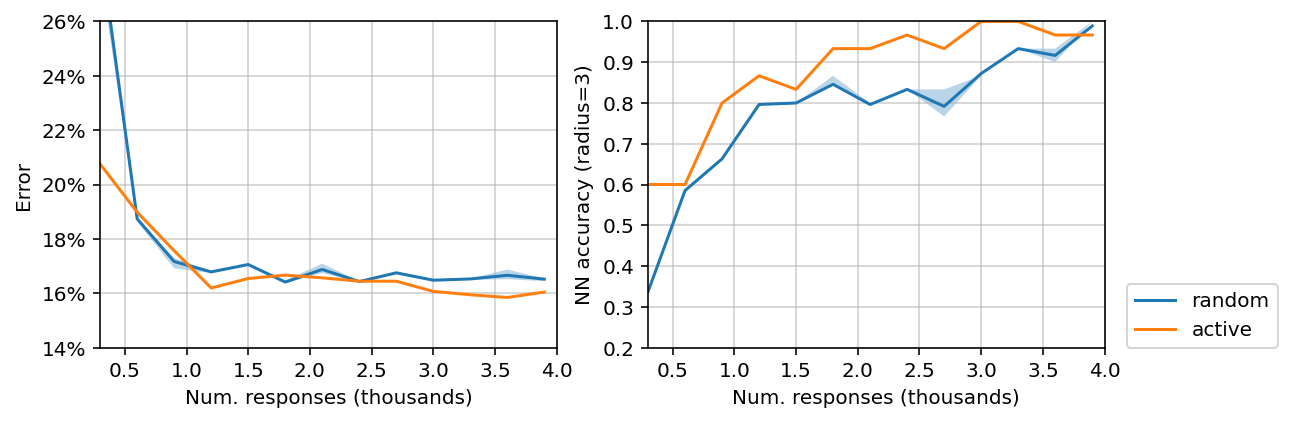

In [23]:
fig, axs = plt.subplots(figsize=(3.0 * w, 1.0 * w), ncols=2)
y = "error"
ax = lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
#     marker="o",
    data=s,
    estimator="mean",
    ci=0.25,
    ax=axs[0],
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax.set_xlim(0.3, 4)

_ = ax.set_ylim(0.14, 0.26)

ax.set_ylabel("Error")
ax.legend_.remove()

y = "nn_diff_2"
r = int(y.split("_")[-1]) + 1
ax = lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=s,
    ci=0.25,
    estimator="mean",
    ax=axs[1],
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.set_ylim(0.2, 1)
ax.set_ylabel(f"NN accuracy (radius={r})")
# ax.set_ylim(0, 3)
ax.set_xlim(0.3, 4)
# ax.set_title(f"{y}")

ax.legend(loc=(1.05, 0))
# fig.savefig("synth-eg-acc.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Avg. # of nodes\nbetween point and NN')

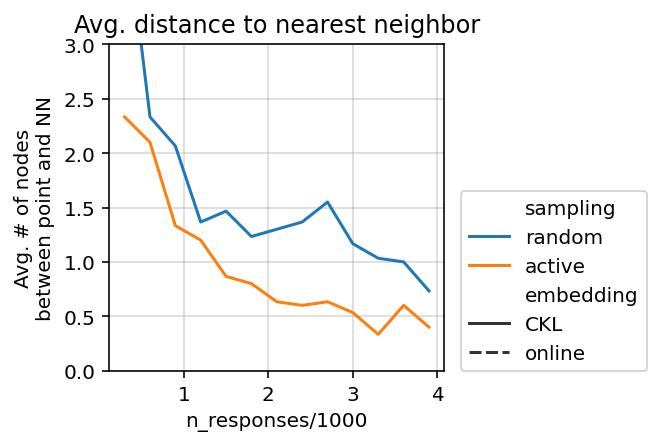

In [27]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "nn_diff_mean"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
    ci=None,
    estimator="median",
)
# ax.set_ylim(None, 0.3)
ax.grid(alpha=0.5)
ax.set_title(f"{y}")
ax.legend(loc=(1.05, 0))
ax.set_ylim(0, 3)
ax.set_title("Avg. distance to nearest neighbor")
ax.set_ylabel("Avg. # of nodes\nbetween point and NN")

In [25]:
show.columns

Index(['d', 'max_queries', 'n', 'sampling', 'skip_button', 'ident',
       'est__dwell', 'est__verbose', 'est__random_state', 'est__max_epochs',
       'n_train', 'n_test', 'n_responses', 'noise_model', 'threads', 'alg',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_error', 'embedding_rel_error',
       'procrustes_disparity', 'nn_diff_0'

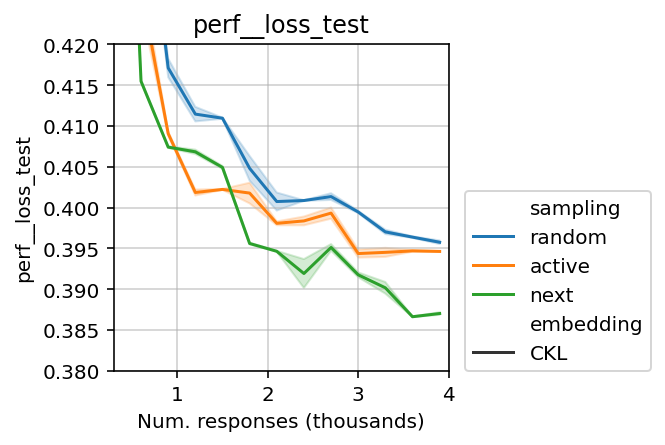

In [73]:
w = 3
fig, ax = plt.subplots(figsize=(1 * w, 1.0 * w))
y = "perf__loss_test"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
    ax=ax,
    ci="sd",
    estimator="median",
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_ylim(0.38, 0.42)
# ax.set_ylim(0, 3)
ax.set_xlim(0.3, 4)
ax.set_title(f"{y}")

ax.legend(loc=(1.05, 0))

In [59]:
assert np.allclose(show["nn_acc"], show["nn_diff_0"])

Text(0.5, 1.0, 'nn_diff_2')

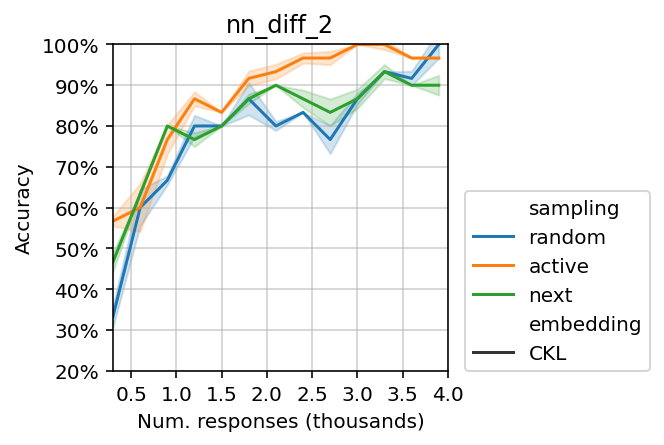

In [60]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
# y = "nn_acc"
y = "nn_diff_2"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
    ci="sd",
    estimator="median",
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

_ = ax.set_ylim(0.20, 1.00)
_ = ax.set_xlim(0.3, 4)

ax.legend(loc=(1.05, 0))
ax.set_ylabel("Accuracy")
ax.set_title(f"{y}")
# ax.set_xscale("log", base=2)
# ax.set_xlim(0, None)

Text(0.5, 1.0, 'nn_diff_mean')

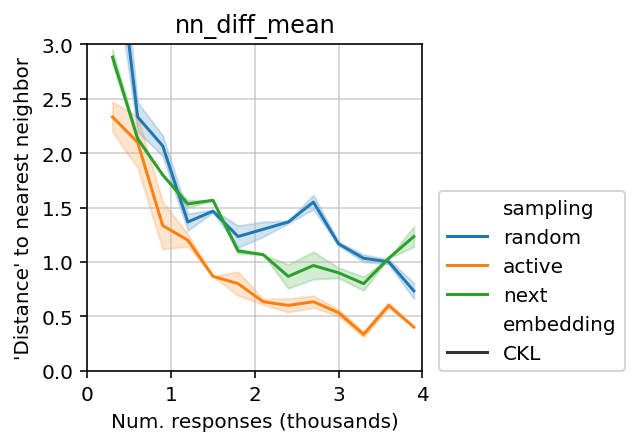

In [61]:
w = 3
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
# y = "nn_acc"
y = "nn_diff_mean"
ax = sns.lineplot(
    x="n_responses/1000",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
    ci="sd",
    estimator="median",
)
ax.set_xlabel("Num. responses (thousands)")
ax.grid(alpha=0.6)
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

_ = ax.set_ylim(0, 3)
_ = ax.set_xlim(0, 4)

ax.legend(loc=(1.05, 0))
ax.set_title("Nearest neighbor accuracy")
ax.set_ylabel("'Distance' to nearest neighbor")
ax.set_title(f"{y}")
# ax.set_xscale("log", base=2)
# ax.set_xlim(0, None)

(0.0, 30.0)

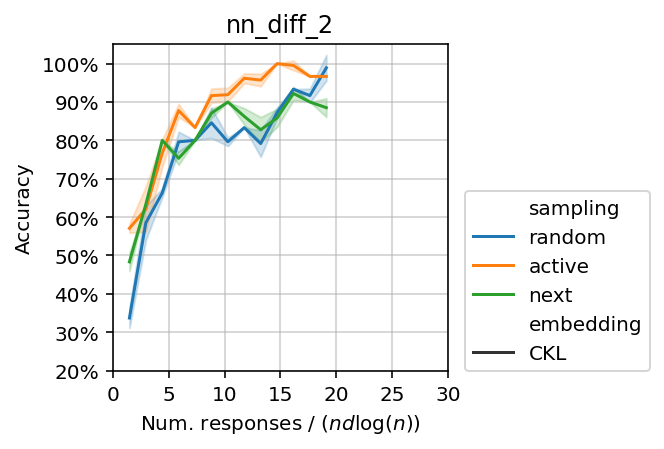

In [62]:
w = 3
y = "nn_diff_2"
fig, axs = plt.subplots(figsize=(1 * w, 1.0 * w))
ax = sns.lineplot(
    x="n_responses/prob",
    y=y,
    hue="sampling",
    hue_order=HUE_ORDER,
    style="embedding",
    data=show,
    ci="sd",
)
ax.set_xlabel("Num. responses / $(nd\log(n))$")
ax.grid(alpha=0.6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{100 * y:0.0f}%"))
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.set_xlim(0, 4)

_ = ax.set_ylim(0.20, 1.05)
_ = ax.set_xlim(0, 30)

ax.legend(loc=(1.05, 0))
ax.set_title(f"{y}")
ax.set_ylabel("Accuracy")
# ax.set_xscale("log", base=2)
ax.set_xlim(0, None)

In [63]:
_idx = show.pivot_table(
    index="sampling",
    values="accuracy",
    aggfunc=lambda x: np.abs(x - 0.82).idxmin(),
)
idx = {k: int(v) for k, v in dict(_idx["accuracy"]).items()}
for i in idx.values():
    s = show.loc[i, ["accuracy", "sampling", "n_responses"]]
    print(s)

accuracy       0.823866
sampling         active
n_responses         900
Name: 257, dtype: object
accuracy       0.822123
sampling           next
n_responses         600
Name: 1222, dtype: object
accuracy       0.824614
sampling         random
n_responses         900
Name: 486, dtype: object


In [64]:
df.columns

Index(['d', 'max_queries', 'n', 'sampling', 'skip_button', 'ident',
       'est__dwell', 'est__verbose', 'est__random_state', 'est__max_epochs',
       'n_train', 'n_test', 'n_responses', 'noise_model', 'threads', 'alg',
       'perf__pf_calls', 'perf__num_answers', 'perf__model_updates',
       'perf__num_grad_comps', 'perf__answers_bytes', 'perf__score_train',
       'perf__loss_train', 'perf__k', 'perf__elapsed_time', 'perf__train_data',
       'perf__n', 'perf__d', 'perf__max_epochs', 'perf__verbose',
       'perf__ident', 'perf___epochs', 'perf__last_score', 'perf__score_test',
       'perf__loss_test', 'perf___elapsed_time', 'accuracy', 'nn_diff_median',
       'nn_diff_mean', 'nn_acc', 'nn_diff_p99', 'nn_diff_p95', 'nn_diff_p90',
       'nn_diff_p80', 'nn_diff_p70', 'nn_diff_p60', 'nn_diff_p50',
       'nn_diff_p40', 'nn_diff_p30', 'nn_diff_p20', 'nn_diff_p10',
       'nn_diff_p5', 'nn_diff_p1', 'embedding_error', 'embedding_rel_error',
       'procrustes_disparity', 'nn_diff_0'

(0.0, 5000.0)

(0.0, 5000.0)

(0.0, 5000.0)

(0.0, 5000.0)

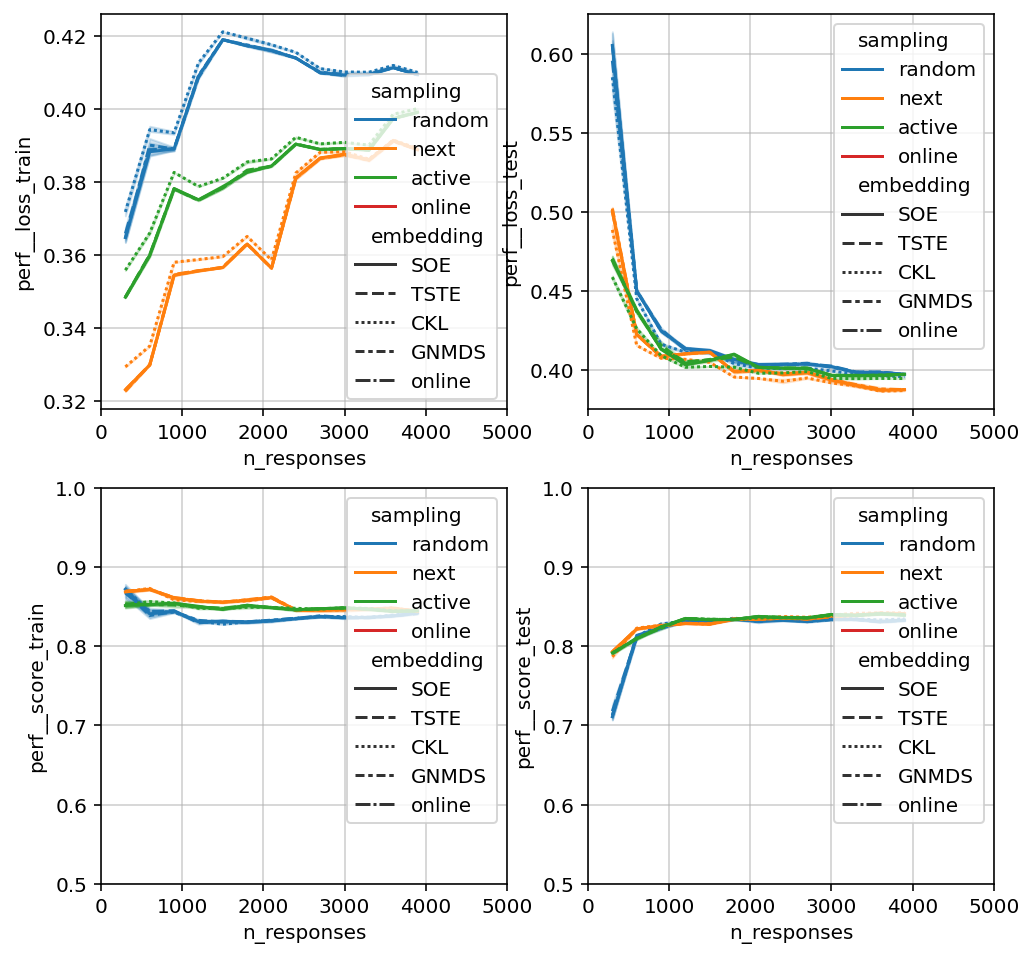

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

Y = ["accuracy", "nn_acc", "embedding_rel_error", "nn_diff_mean"]
Y = ["perf__loss_train", "perf__loss_test", "perf__score_train", "perf__score_test"]

w = 4
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(2 * w, 2.0 * w))
for y, ax in zip(Y, axs.flatten()):
    ax = sns.lineplot(
        x="n_responses",
        y=y,
        hue="sampling",
        style="embedding",
        data=df,
        ax=ax,
    )
    ax.grid(alpha=0.6)
    if "score" in y:
        _ = ax.set_ylim(0.5, 1)
    ax.set_xlim(0, 5000)
#     ax.set_xscale("log")
#     _ = ax.set_title(y)
# axs[0][1].set_ylim(0, 2)